# Title

---
embed-resources: true
---

## Introduction

The purpose of this report is to create an automatic fraud detector for credit card transactions within our banking institution. Using information available at the time of the transaction, things like location and amount, we will create a model that will predict if the transaction is genuine or fraudulant.

## Methods

In [13]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score, precision_score, recall_score, confusion_matrix

### Data

In [14]:
# load data
fraud_train = pd.read_parquet(
    "https://cs307.org/lab/data/fraud-train.parquet",
)
fraud_test = pd.read_parquet(
    "https://cs307.org/lab/data/fraud-test.parquet",
)

# create X and y for train
X_train = fraud_train.drop("Fraud", axis=1)
y_train = fraud_train["Fraud"]

# create X and y for test
X_test = fraud_test.drop("Fraud", axis=1)
y_test = fraud_test["Fraud"]

Each observation contains 28 principal components derived from various relevant data points about the transaction, as well as the amount of the transaction. The data dictionary is detailed below.

### Response
**`Fraud`**
- [int64] status of the transaction. 1 indicates a fraudulent transaction and 0 indicates not fraud, a genuine transaction.

### Features
**`Amount`**
- [float64] amount (in dollars) of the transaction.

**`PC01 - PC28`**
- [float64] the 28 principal components that encode information such as location and type of purchase while preserving customer privacy.

In [15]:
# | echo: False
fraud_train

,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,Amount,Fraud
137250,-0.514509,0.899378,1.627215,-0.142250,0.005250,-0.235422,0.482540,0.247403,-0.562327,-0.166813,1.578158,0.401864,-0.840984,0.525029,0.464908,0.077435,-0.249661,-0.282406,-0.127125,0.024170,-0.143290,-0.390205,0.030719,0.184779,-0.348711,0.073253,0.273217,0.107938,3.59,0
132979,-0.813568,-0.373893,1.152977,-0.449774,-3.868866,2.780636,3.654192,-0.672442,0.753230,-0.662803,1.120128,0.074297,-1.085441,-0.843601,-0.643903,-0.083718,-0.125207,-0.336843,0.504719,-0.360373,-0.376783,-0.004239,0.074801,0.124238,-0.448493,0.861423,-0.093639,-0.711632,798.01,0
78191,-2.443142,3.258831,-0.791511,0.223548,0.007932,-1.263044,1.220214,-0.418068,1.860453,4.184883,-0.020469,0.280016,0.606572,-0.815812,0.823581,-0.998437,-0.458679,-0.437049,0.051311,1.668704,-0.348587,0.531679,0.058990,0.371638,-0.207398,-0.505837,0.524542,-0.343895,1.79,0
113508,-0.397300,0.922104,1.224699,-0.334974,0.322603,-0.117372,0.534683,0.175550,-0.486404,-0.120147,0.433718,-0.027480,-0.648805,0.436365,0.289163,0.670658,-0.902195,0.503410,0.619992,0.086845,-0.239303,-0.695001,-0.128231,-0.536463,-0.138971,0.107526,0.255644,0.100814,2.69,0
199222,1.994046,-0.367813,-0.462867,0.338661,-0.485326,-0.241576,-0.590987,0.089319,1.413224,-0.149292,-0.990824,-0.015069,-0.825693,0.139040,0.850457,0.221652,-0.477098,-0.114002,-0.106542,-0.267729,-0.196388,-0.484457,0.421867,0.601393,-0.448014,-0.646256,0.027632,-0.027244,4.49,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76424,-0.033583,-0.487672,1.435406,-2.759369,-1.785638,0.402364,-2.306038,-2.287179,0.129717,-1.036412,1.160731,0.695937,-0.842226,0.542820,1.391424,-1.172378,-0.123146,2.115902,-1.080178,0.104458,-1.286823,0.824100,0.018890,0.000018,0.301618,0.081215,0.163422,0.252456,10.00,0
264579,-0.731245,1.151677,0.912393,-0.653540,0.700577,-0.461372,1.093273,-0.126254,-0.339171,-0.467356,-1.530725,-0.586003,-0.461481,0.201004,0.193925,-0.136793,-0.330243,-0.372686,0.897630,0.103744,-0.368185,-0.991854,-0.376461,-0.661608,0.554237,0.450650,0.076395,0.096252,6.99,0
204332,2.135923,-0.714182,-1.842502,-0.587267,0.090754,-0.465733,-0.024834,-0.328747,-0.659832,0.853241,-1.552561,0.028154,0.864565,0.097304,-0.152669,-1.555239,-0.257337,0.704338,-0.338510,-0.423592,-0.537267,-1.081138,0.196589,0.087797,-0.111583,0.479888,-0.082523,-0.053305,64.90,0
167301,-0.335632,0.939736,-2.961515,-1.224739,4.446891,2.352092,0.789725,0.609460,-0.746845,-1.580751,0.607414,-0.691359,-0.680671,-2.314636,0.008727,0.235219,2.027587,0.536374,-0.578802,-0.104663,-0.002116,0.009686,-0.428325,0.536043,0.278736,0.680976,-0.069295,0.051891,0.76,0


The dataset has 54276 samples and 29 features.

In [16]:
# | echo: False
# summary statistics
pd.concat([fraud_train['Fraud'].value_counts(), fraud_train['Fraud'].value_counts(normalize=True)],axis=1)

,count,proportion
Fraud,,
0,53961,0.994196
1,315,0.005804


There is massive class imbalance in the training data; 99.4% are genuine transactions and 0.6% are fraudulent.

In [17]:
# | echo: False
both = fraud_train['Amount'].describe().rename("Overall")
not_fraud = fraud_train[fraud_train['Fraud'] == 0]['Amount'].describe().rename("Genuine")
fraud = fraud_train[fraud_train['Fraud'] == 1]['Amount'].describe().rename("Fraudulent")
df = pd.concat([both, not_fraud, fraud], axis=1)
df

,Overall,Genuine,Fraudulent
count,54276.000000,53961.000000,315.000000
mean,88.197903,88.065104,110.947016
std,241.535617,241.451144,254.978960
min,0.000000,0.000000,0.000000
25%,5.490000,5.500000,1.000000
50%,21.690000,21.800000,6.990000
75%,76.000000,75.970000,99.990000
max,10199.440000,10199.440000,2125.870000


Fraudulant transactions cleary show a higher mean and a lower median.

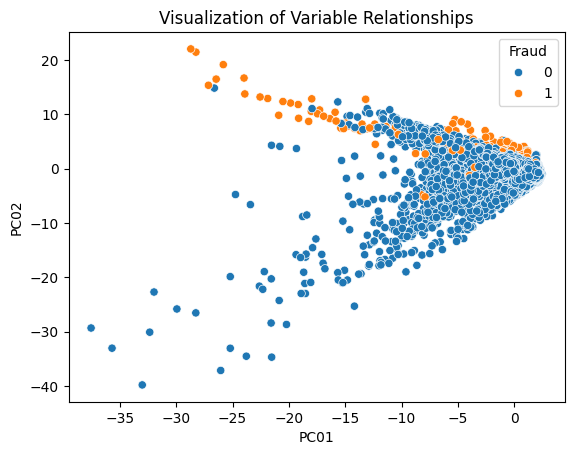

In [26]:
# | echo: False
#  exploratory visualization
sns.scatterplot(x='PC01', y='PC02', hue='Fraud', data=fraud_train)
plt.title("Visualization of Variable Relationships")
plt.show()

This visualization shows how `PC01` and `PC02` relate to `Fraud`. There is some separation between where the data points lie.

### Models

In [19]:
# process data for ML
features = fraud_train.drop('Fraud', axis=1).columns
target = 'Fraud'

numeric_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
    ],
)

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_pipeline, features)
    ],
    remainder='drop'
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('estimator', DecisionTreeClassifier())
    ]
)

We will use a Decision Tree Classifier to predict `Fraud`. We will impute missing values with the median and not perform any scaling.

In [20]:
# train models

param_grid = {
    'estimator__class_weight': [
        {0: 1, 1: 1},
        {0: 1, 1: 2},
        "balanced",
    ],
    'estimator__max_depth': range(1, 20, 2)
}

scoring = {
    "accuracy": make_scorer(accuracy_score),
    "recall": make_scorer(recall_score),
    "precision": make_scorer(precision_score, zero_division=0),
    "f1": make_scorer(fbeta_score, beta=1),
}

model = GridSearchCV(pipeline, param_grid, scoring=scoring, cv=5, refit='f1')

_ = model.fit(X_train, y_train)

In [21]:
# helper function to print cross-validation results
def print_metric_scores(grid, metric):
    cv_results = grid.cv_results_
    best_index = grid.best_index_
    mean_score = cv_results[f"mean_test_{metric}"][best_index]
    std_score = cv_results[f"std_test_{metric}"][best_index]
    print(f"CV {metric} (mean ± std): {mean_score:.3f} ± {std_score:.3f}")

print_metric_scores(model, "accuracy")
print_metric_scores(model, "precision")
print_metric_scores(model, "recall")
print_metric_scores(model, "f1")

model.best_params_

CV accuracy (mean ± std): 0.998 ± 0.000
CV precision (mean ± std): 0.906 ± 0.046
CV recall (mean ± std): 0.813 ± 0.044
CV f1 (mean ± std): 0.856 ± 0.036


{'estimator__class_weight': {0: 1, 1: 2}, 'estimator__max_depth': 3}

After parameter tuning with cross validation, the chosen model uses class weights of 1:2 and a max tree depth of 3. The test dataset achieves an accuracy of 0.998 with a precision of 0.906 and recall of 0.813. The best model was chosen with an f1 score.

## Results

In [29]:
# report model metrics
y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = precision_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Test Precision: {test_precision:.3f}")
print(f"Test Recall: {test_recall:.3f}")

Test Accuracy: 0.999
Test Precision: 0.928
Test Recall: 0.928


In [ ]:
# | echo: false
# | output: false
# serialize model
dump(model, 'fraud.joblib')

['fraud.joblib']

## Discussion

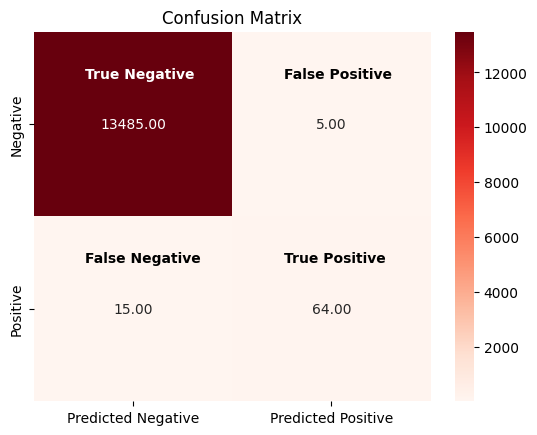

In [25]:
# | echo: False
# | lightbox: True
# summary figure
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Reds', annot=True, fmt='.2f', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Negative', 'Positive'])
plt.text(0.26,0.25, 'True Negative', fontdict={'color': 'white', 'weight': 'bold'})
plt.text(1.26,0.25, 'False Positive', fontdict={'color': 'black', 'weight': 'bold'})
plt.text(0.26,1.25, 'False Negative', fontdict={'color': 'black', 'weight': 'bold'})
plt.text(1.26,1.25, 'True Positive', fontdict={'color': 'black', 'weight': 'bold'})
plt.title("Confusion Matrix")
plt.show()

I would recommend against putting this model into practice. Out of approximately 54,000 transactions, there were 5 false positives and 15 false negatives. See the above visualization. A false negative means that the transaction was classified as genuine but was fraudulent. A false positive means that the transaction was classified as fraudulent but was genuine. When a false negative occurs, a customer will either notice the fraud and inform the bank, or the fraud may go unnoticed. In this situation, the customer will likely be unhappy that the bank failed to detect the fraudulent transaction. When a false positive occurs, a customer making a genuine transaction will be declined, and they will have to call the bank and ask for the transaction to go through. Both situations cause an inconvenience to the customer, although the immediacy of a transaction being declined may be of greater importance to the customer. Either way, since our bank handles such a vast number of transactions, I do not think that the false negative rates and false positive rates are low enough. Too many remediations will have to be manually performed.